# Community Detection

<hr style="border:2px solid black"> </hr>

## Notebook 02.01 - Perform Louvain's algorithm on network, only considering edges with 2+ shared users

Create a recipe graph with weighted edges based on users. Analyze the graph to detect user communities, and use the distance between communities to calculate similarity scoring. 

**Note** - this was run on AWS cloud, so filepaths are not relative to the repository folder and some references may need to be updated.

---

### Import libraries

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import networkx as nx
import networkx.algorithms.community as nx_comm
import sys
from node2vec import Node2Vec
from sagemaker import get_execution_role
import boto3

In [4]:
def num_uniques(ser):
    try:
        return len(ser.unique())
    except:
        return "Not unique check-able"

In [5]:
def summarize_df(df):
    print("======DATA SUMMARY======")
    print("{} rows by {} columns".format(df.shape[0], df.shape[1]))
    print("\n======COLUMNS======")
    print(df.dtypes)
    print("\n======PREVIEW======")
    display(df.head())
    print("\n======NUMERICAL COL SUMMARY======")
    print(df.describe())
    print("\n")
    for col in df.columns:
        print("{}: {} unique values".format(col, num_uniques(df[col])))

---
### Create network and analyze communities

In [6]:
def determine_communities(shared_users):
    # Creating graph
    print("Creating graph variable in networkx...")
    print(time.asctime(time.localtime(time.time())))
    G = nx.from_pandas_edgelist(df=shared_users, source='recipe_id', target='recipe_id_2', edge_attr='pct_users')
    
    # Checking to see how many disconnected subgraphs were created by sampling method
    print("\nAnalyzing disconnected subgraphs...")
    print(time.asctime(time.localtime(time.time())))
    comps = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    print("There are {} disconnected subgraphs in G".format(len(comps)))
    print(comps)
    
    # Community analysis using Louvain's algorithm
    print("\nDetecting communities...")
    print(time.asctime(time.localtime(time.time())))
    louvain_communities = nx_comm.louvain_communities(G, weight='pct_users')
    print("There are {} communities".format(len(louvain_communities)))
    
    return G, louvain_communities

In [7]:
def analyze_communities(G, louvain_communities):
    # Evaluate partitions modularity
    print("Evaluating modularity..")
    l_mod = nx_comm.modularity(G, louvain_communities, weight='pct_users')
    print("Louvain modularity is {}".format(l_mod))
    
    # Evaluate partitions coverage and performance
    print("\nEvaluating coverage and performance..")
    l_coverage, l_perform = nx_comm.quality.partition_quality(G, louvain_communities)
    print("Louvain coverage is {:.3f} and performance is {:.3f}".format(l_coverage, l_perform))
    
    # Create assignments dataframe
    print("\nDetermining assignments dataframe...")
    louvain_assignments = pd.DataFrame([[node, ind] for ind, node_set in enumerate(louvain_communities) for node in node_set],
                                   columns=['recipe_id', 'community_id'])
    
    # Determine community sizes
    print("\nDetermining sizes of communities...")
    community_sizes = np.array([[i, len(a)] for i, a in enumerate(louvain_communities)])
    community_sizes = pd.DataFrame(community_sizes[community_sizes[:, 1].argsort()[::-1]], columns=['community_id', 'size'])
    print("Top 5 community sizes")
    print(community_sizes[:5])
    
    return l_mod, l_coverage, l_perform, louvain_assignments, community_sizes

In [8]:
def determine_intercommunity_distance(shared_users, louvain_communities, louvain_assignments):
    # Join clusters to shared users
    print("Joining clusters to user-level file...")
    print(time.asctime(time.localtime(time.time())))
    shared_users = shared_users.merge(louvain_assignments, on='recipe_id')
    shared_users = shared_users.merge(louvain_assignments, left_on='recipe_id_2', right_on='recipe_id', suffixes=('', '_r')) \
                            .drop('recipe_id_r', axis=1) \
                            .rename({'community_id_r':'community_id_2'}, axis=1)
    
    # Calculate the median distance between clusters
    print("\nCalculating median distance between clusters...")
    print(time.asctime(time.localtime(time.time())))
    comms = shared_users[['community_id', 'community_id_2', 'pct_users']] \
                    .groupby(by=['community_id', 'community_id_2']) \
                    .agg({'pct_users': ['median']}) \
                    .reset_index()
    comms = comms[comms['community_id'] <= comms['community_id_2']]
    comms.columns = comms.columns.map('_'.join)
    comms = comms.rename({'community_id_': 'community_id', 'community_id_2_': 'community_id_2'}, axis=1)
    
    # Invert weights for distance calculation
    print("\nInverting weights for distance calculation...")
    print(time.asctime(time.localtime(time.time())))
    comms['pct_users_median_inv'] = comms['pct_users_median'].max() - comms['pct_users_median'] \
                                + comms['pct_users_median'].min()
    
    
    # Create community graph and check subgraphs
    print("\nCreating community graph and checking subgraphs...")
    print(time.asctime(time.localtime(time.time())))
    comm_G = nx.from_pandas_edgelist(df=comms, source='community_id', target='community_id_2',
                                     edge_attr=['pct_users_median', 'pct_users_median_inv'])
    comm_comps = [len(c) for c in sorted(nx.connected_components(comm_G), key=len, reverse=True)]
    print("There are {} disconnected subgraphs in the community graph".format(len(comm_comps)))
    print(comm_comps)

    
    # Use dijkstra's algorithm to calculate all to all distances
    print("\nCalculating distances...")
    print(time.asctime(time.localtime(time.time())))
    comm_dists = dict(nx.all_pairs_dijkstra_path_length(comm_G, weight='pct_users_median_inv'))
    comm_dists = pd.DataFrame([[source, dest, dist] for source, dists in comm_dists.items() for dest, dist in dists.items()], 
                                 columns=['community_id', 'community_id_2', 'community_distance'])
    comm_dists = comm_dists[comm_dists['community_id'] != comm_dists['community_id_2'] ]
    print("Complete")
    
    return comms, comm_dists, comm_comps
    

In [11]:
# Import data
role = get_execution_role()
bucket='sagemaker-cse-6242'
data_key = 'clustering_data_filtered_pctthresh-08'
data_location = 's3://{}/{}'.format(bucket, data_key)
shared_users = pd.read_parquet(data_location)

In [12]:
# Assign communities
G, l_communities = determine_communities(shared_users)

Creating graph variable in networkx...
Mon Apr 11 18:21:53 2022

Analyzing disconnected subgraphs...
Mon Apr 11 18:24:18 2022
There are 15 disconnected subgraphs in G
[83331, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Detecting communities...
Mon Apr 11 18:24:33 2022
There are 31 communities


In [13]:
# Evaluate communities
l_mod, l_coverage, l_perform, l_assign, comm_sizes = analyze_communities(G, l_communities)

Evaluating modularity..
Louvain modularity is 0.46427852929002955

Evaluating coverage and performance..
Louvain coverage is 0.526 and performance is 0.839

Determining assignments dataframe...

Determining sizes of communities...
Top 5 community sizes
   community_id   size
0             8  23148
1             6  20144
2            14   9918
3             7   5321
4            25   3367


In [14]:
comm_sizes.describe()

,community_id,size
count,31.000000,31.000000
mean,15.000000,2689.032258
std,9.092121,5486.465155
min,0.000000,2.000000
25%,7.500000,2.000000
50%,15.000000,768.000000
75%,22.500000,2497.500000
max,30.000000,23148.000000


In [15]:
# Determine intercommunity distances
comms, c_dists, c_comps = determine_intercommunity_distance(shared_users, l_communities, l_assign)

Joining clusters to user-level file...
Mon Apr 11 18:43:36 2022

Calculating median distance between clusters...
Mon Apr 11 18:43:53 2022

Inverting weights for distance calculation...
Mon Apr 11 18:43:56 2022

Creating community graph and checking subgraphs...
Mon Apr 11 18:43:56 2022
There are 15 disconnected subgraphs in the community graph
[17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Calculating distances...
Mon Apr 11 18:43:56 2022
Complete


In [16]:
def visualize_community_graph(comms, node_sizes, k=0.4, alpha=0.9):
    edge_list = [(r[0],r[1]) for r in np.array(comms[comms['community_id'] != comms['community_id_2']][['community_id', 'community_id_2']])]
    G = nx.from_pandas_edgelist(df=comms, source='community_id', target='community_id_2', 
                                edge_attr=['pct_users_median'])
    node_sizes = node_sizes[node_sizes['community_id'].apply(lambda x: x in list(G.nodes()))]
    node_list = node_sizes['community_id']
    node_sizes = node_sizes['size']/20
#     weights = list(nx.get_edge_attributes(G,'pct_users_median').values())
#     widths = [int((a - min(weights[:-1]))/(max(weights[:-1]) - min(weights[:-1]))*4) for a in weights]
#     print(widths)
    plt.figure(figsize=(5, 4))
    nx.draw(G, nodelist=node_list, node_size=node_sizes, edgelist=edge_list, width=0.2,
            alpha=alpha, pos=nx.spring_layout(G, weight='pct_users_median', k=k))

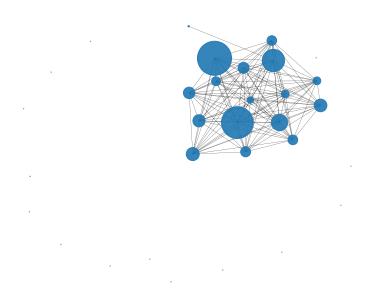

In [17]:
visualize_community_graph(comms, comm_sizes, k=0.7)

---
### Check all recipes are in the assignments

In [18]:
# Import data
role = get_execution_role()
bucket='sagemaker-cse-6242'
data_key = 'users_in_count2_mean4.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
u_recipes = pd.read_csv(data_location)['recipe_id'].unique()

In [19]:
# Import data
role = get_execution_role()
bucket='sagemaker-cse-6242'
data_key = 'recipes_in_count2_mean4.parquet'
data_location = 's3://{}/{}'.format(bucket, data_key)
r_recipes = pd.read_parquet(data_location).reset_index()['recipe_id'].unique()

In [20]:
assign_recipes = l_assign['recipe_id'].unique()

In [21]:
def check_recipes(list_og, list_check):
    missing = []
    for r in list_og:
        if r not in list_check:
            missing += [r]
    
    print("{} of {} recipes missing".format(len(missing), len(list_og)))
    return missing

In [22]:
u_recipes_missing = check_recipes(u_recipes, assign_recipes)

2159 of 85519 recipes missing


In [23]:
r_recipes_missing = check_recipes(r_recipes, assign_recipes)

1202 of 48454 recipes missing


---
### Check all distances are accounted for

In [24]:
def check_distance(louvain_communities, comm_dist):
    expected = len(louvain_communities)**2 - len(louvain_communities)
    got = comm_dist.shape[0]
    print("Expected {} distance records, got {}".format(expected, got))

In [25]:
c_dists

,community_id,community_id_2,community_distance
1,0,9,0.375619
2,0,14,0.375619
3,0,16,0.375619
4,0,3,0.393476
5,0,5,0.393476
...,...,...,...
288,29,27,0.780417
289,29,1,0.786953
290,29,4,0.786953
291,29,13,0.786953


In [26]:
len(l_communities)

31

In [27]:
check_distance(l_communities, c_dists)

Expected 930 distance records, got 272


In [40]:
# Write out files
# Community assignments
data_key = 'community_assignments_pctthresh-08.parquet'
l_assign.to_parquet(data_key)

# Community distances
data_key = 'community_distances_pctthresh-08.parquet'
c_dists.to_parquet(data_key)

# Community graph edges
data_key = 'community_graph_edges_pctthresh-08.parquet'
comms.to_parquet(data_key)

# Community graph subgraphs
data_key = 'community_graph_subg_pctthresh-08.parquet'
np.savetxt(data_key, np.array(c_comps))